# Event Handling in Python

See how easy it is to define an `EventHandler` in
Python.
Might sometimes make sense for analysis, if one wants to analyse the
results unsing pandas.

## Setup

In [1]:
import jpype as jp
import jpype.imports as jimport
import os
from shutil import rmtree
import pandas as pd
%matplotlib inline

In [2]:
jimport.registerDomain('org')

classpath = os.pathsep.join(('matsim-0.10.1/matsim-0.10.1.jar', 'matsim-0.10.1/lib/*'))
jp.startJVM(jp.getDefaultJVMPath(), '-Djava.class.path=%s' % classpath)

In [3]:
from org.matsim.core.scenario import ScenarioUtils
from org.matsim.core.config import ConfigUtils
from org.matsim.api.core.v01 import Id
from org.matsim.core.controler import Controler
from org.matsim.core.controler.OutputDirectoryHierarchy import OverwriteFileSetting
from org.matsim.api.core.v01.events.handler import LinkEnterEventHandler, LinkLeaveEventHandler

##  Setup Scenario

Setup a simple scenario.

In [21]:
config = ConfigUtils.loadConfig('matsim-0.10.1/examples/equil/config.xml')
config.controler().setLastIteration(10)
config.controler().setOverwriteFileSetting(OverwriteFileSetting.deleteDirectoryIfExists)

scenario = ScenarioUtils.loadScenario(config)

## Define Event Handler

Define a Python class to handle events and put it
behind proxies of type
`LinkLeaveEventHandler` and `LinkEnterEventHandler`.

In [33]:
class MyLinkLeaveHandler:
    ####################################################################
    # Methods for the python side
    ####################################################################
    def __init__(self):
        self.stored_records = []

    def get_events_table(self):
        return pd.DataFrame.from_records(self.stored_records)

    ####################################################################
    # Methods for the java side
    ####################################################################
        
    def handleEvent(self, event):
        # This method will receive all events, as polymorphic dispatch is
        # not possible in Python. Here this is actually nice, but could be
        # annoying in other cases.
        self.stored_records.append(
            {
                'time': event.getTime(),
                # Not using toString stores the IDs as java objects. That works fine
                # for lots of purpose, but not all (for instance groupBy)
                'link': event.getLinkId().toString(),
                'type': event.getEventType()})
        
    def reset(self, iteration):
        self.stored_records = []
    
    # JProxy does not provide default implementation for those methods:
    # provide one, to avoid crashes.
    # In true python way, the JProxy checks if a method exists only if actually
    # invoked.
    def hashCode(self):
        return 42
    
    def toString(self):
        return "%s" % self

handler = MyLinkLeaveHandler()
handlerProxy = jp.JProxy((LinkLeaveEventHandler, LinkEnterEventHandler), inst=handler)

## Run Simulation

In [23]:
controler = Controler(scenario)

controler.getEvents().addHandler(handlerProxy)

controler.run()
rmtree('output/')
table = handler.get_events_table()

## Analysis

We now have access to the link enter and leave events as a pandas table.

In [32]:
table

,link,time,type
0,1,21511.0,left link
1,6,21511.0,entered link
2,1,21541.0,left link
3,6,21541.0,entered link
4,1,21571.0,left link
5,6,21571.0,entered link
6,1,21601.0,left link
7,6,21601.0,entered link
8,1,21601.0,left link
9,9,21601.0,entered link


We can use matplotlib, for instance to look at when events occured:

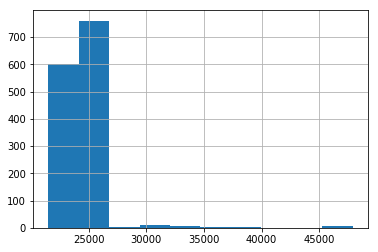

In [25]:
table.time.hist()

Or use anything pandas gives us for quick analysis. For instance, sort links
from least to most used:

In [30]:
table.groupby('link').time.count().sort_values()

link
17      4
8       4
5      10
12     10
14     10
3      10
9      16
10     16
13     16
4      16
18     16
19     16
2      22
11     22
16     28
7      28
15     78
6      78
21    200
22    200
23    200
20    200
1     200
Name: time, dtype: int64